# Libraries and Dataset

In [1]:
# Libraries

# Standard
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', None)

# Preprocessing

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle

# Modeling

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.svm import SVC
from catboost import CatBoostClassifier
# Tensorflow will be handled separately as this library requires a specific numpy version, which are but incompatible with other librairies like catboost.


# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Feature importance
import shap 

# Saving models

import joblib
import os


c:\Users\alexa\anaconda3\envs\employee_attrition_dec24\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import Dataset

output_path = r"C:\Users\alexa\OneDrive\AlexPerez\Dokumente\2 Soros\Data Science\Projects\employee_attrition_Dec24\data\raw\employee_attrition_synthetic_IT.csv"
df= pd.read_csv(output_path)

# Remove Employee_ID column
if 'Employee_ID' in df.columns:
    df = df.drop(columns=['Employee_ID'])
    print("'Employee_ID' column removed.")
else:
    print("'Employee_ID' column not found.")

display(df.head())
display(df.info())

'Employee_ID' column removed.


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Age,Tenure,Gender,Department,Salary,Overtime,Distance_to_Work,Attrition
0,4,4,5,5,5,4,5,5,4,4,4,4,5,5,4,5,43,2,Male,Development,104715,Yes,0.00,No
1,5,5,4,5,4,4,5,5,5,4,4,5,5,4,5,4,50,1,Female,QA,73815,No,8.71,No
2,1,1,1,2,2,2,2,1,2,1,1,1,1,1,1,2,44,4,Male,Development,76687,Yes,0.00,Yes
3,2,2,1,1,2,2,2,2,1,1,1,2,2,1,1,1,42,0,Male,Development,99861,No,0.00,Yes
4,5,5,5,5,5,5,5,4,4,4,5,4,5,5,4,5,37,4,Male,Support,115343,No,4.62,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Q1                5000 non-null   int64  
 1   Q2                5000 non-null   int64  
 2   Q3                5000 non-null   int64  
 3   Q4                5000 non-null   int64  
 4   Q5                5000 non-null   int64  
 5   Q6                5000 non-null   int64  
 6   Q7                5000 non-null   int64  
 7   Q8                5000 non-null   int64  
 8   Q9                5000 non-null   int64  
 9   Q10               5000 non-null   int64  
 10  Q11               5000 non-null   int64  
 11  Q12               5000 non-null   int64  
 12  Q13               5000 non-null   int64  
 13  Q14               5000 non-null   int64  
 14  Q15               5000 non-null   int64  
 15  Q16               5000 non-null   int64  
 16  Age               5000 non-null   int64  


None

# Preprocessing

In [3]:
# Separate features and target
X = df.drop(columns=['Attrition']) 
y = df['Attrition']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train-test split completed.")

## No need to use stratified sampling, because SMOTE will be used?


Train-test split completed.


In [4]:
# Encoding categorical variables

# Define categorical and numerical features
categorical_features = ['Gender', 'Department', 'Overtime']
numerical_features = ['Age', 'Tenure', 'Salary', 'Distance_to_Work']

# One-Hot Encoding for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse=False), categorical_features)
    ],
    remainder='passthrough'  # Keep numerical features as they are for now
)

# Apply One-Hot Encoding on training and test sets
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

print("Categorical variables encoded.")


Categorical variables encoded.


c:\Users\alexa\anaconda3\envs\employee_attrition_dec24\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [5]:
# Scaling numerical features

# Initialize RobustScaler
scaler = RobustScaler()

# Apply RobustScaler to numerical features only
X_train_encoded[:, -len(numerical_features):] = scaler.fit_transform(
    X_train_encoded[:, -len(numerical_features):]
)
X_test_encoded[:, -len(numerical_features):] = scaler.transform(
    X_test_encoded[:, -len(numerical_features):]
)

print("Numerical features scaled using RobustScaler.")

Numerical features scaled using RobustScaler.


In [6]:
# Addressing class imbalances

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_encoded, y_train)

# Shuffle the balanced data
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)

print("SMOTE applied to training data. Classes balanced.")


SMOTE applied to training data. Classes balanced.


In [7]:
# Visualizing new shape after SMOTE
print("Shape of X_train before SMOTE:", X_train_encoded.shape)
print("Shape of X_train after SMOTE:", X_train_balanced.shape)
print("Shape of y_train before SMOTE:", y_train.shape)
print("Shape of y_train after SMOTE:", y_train_balanced.shape)


Shape of X_train before SMOTE: (4000, 26)
Shape of X_train after SMOTE: (5068, 26)
Shape of y_train before SMOTE: (4000,)
Shape of y_train after SMOTE: (5068,)


In [12]:
# This was run thereafter, as I was having problems with the python script for the streamlit app. One feature was missing.

# Get feature names for one-hot-encoded columns
one_hot_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

# Identify the Q12+ feature names (if applicable)
q12_features = [col for col in X.columns if col.startswith('Q')]

# Combine all feature names
all_feature_names = list(one_hot_feature_names) + numerical_features + q12_features

# Verify feature names
print("All Feature Names:", all_feature_names)
print("Number of Features:", len(all_feature_names))


All Feature Names: ['Gender_Male', 'Department_Development', 'Department_Management', 'Department_QA', 'Department_Support', 'Overtime_Yes', 'Age', 'Tenure', 'Salary', 'Distance_to_Work', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16']
Number of Features: 26


# Modeling

## Logistic Regression

In [8]:
# Train Logistic Regression
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_model.fit(X_train_balanced, y_train_balanced)

# Evaluate Logistic Regression
y_pred_lr = lr_model.predict(X_test_encoded)
y_pred_prob_lr = lr_model.predict_proba(X_test_encoded)[:, 1]

# Print Evaluation Metrics
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob_lr))

Logistic Regression Results:
              precision    recall  f1-score   support

          No       0.79      0.70      0.74       633
         Yes       0.57      0.69      0.62       367

    accuracy                           0.69      1000
   macro avg       0.68      0.69      0.68      1000
weighted avg       0.71      0.69      0.70      1000

Confusion Matrix:
[[442 191]
 [114 253]]
ROC-AUC Score: 0.7425520100210492


Precision (No: 0.79, Yes: 0.57):
The model performs well in identifying the majority class (No), but struggles to correctly identify the minority class (Yes), as indicated by lower precision for the "Yes" class.

Recall (No: 0.70, Yes: 0.69):
The recall for "Yes" is reasonable (0.69), meaning the model captures a significant portion of employees who left the company.
F1-Score:

The F1-score for "Yes" (0.62) indicates a balance between precision and recall, but it's lower than for "No".
ROC-AUC: 0.74:

Indicates a moderately good ability to distinguish between the two classes.

## SVM

In [11]:
# Train SVM
svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
svm_model.fit(X_train_balanced, y_train_balanced)

# Evaluate SVM
y_pred_svm = svm_model.predict(X_test_encoded)
y_pred_prob_svm = svm_model.predict_proba(X_test_encoded)[:, 1]

# Print Evaluation Metrics
print("SVM Results:")
print(classification_report(y_test, y_pred_svm))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob_svm))

SVM Results:
              precision    recall  f1-score   support

          No       0.79      0.74      0.76       633
         Yes       0.59      0.65      0.62       367

    accuracy                           0.71      1000
   macro avg       0.69      0.70      0.69      1000
weighted avg       0.71      0.71      0.71      1000

Confusion Matrix:
[[468 165]
 [128 239]]
ROC-AUC Score: 0.7173272036192863


Precision (No: 0.79, Yes: 0.59):
Similar to Logistic Regression, SVM has a higher precision for "No" and slightly better precision for "Yes".

Recall (No: 0.74, Yes: 0.65):
SVM captures more "No" cases than Logistic Regression but performs slightly worse for "Yes" cases.

F1-Score:
Comparable to Logistic Regression, with an F1-score of 0.62 for "Yes".

ROC-AUC: 0.72:
Slightly lower than Logistic Regression, indicating similar but slightly weaker performance.

## CatBoost

In [22]:
# Train CatBoost
catboost_model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=0, random_state=42)
catboost_model.fit(X_train_balanced, y_train_balanced)

# Evaluate CatBoost
y_pred_catboost = catboost_model.predict(X_test_encoded)
y_pred_prob_catboost = catboost_model.predict_proba(X_test_encoded)[:, 1]

# Print Evaluation Metrics
print("CatBoost Results:")
print(classification_report(y_test, y_pred_catboost))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_catboost))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob_catboost))

CatBoost Results:
              precision    recall  f1-score   support

          No       0.74      0.78      0.76       633
         Yes       0.58      0.54      0.56       367

    accuracy                           0.69      1000
   macro avg       0.66      0.66      0.66      1000
weighted avg       0.68      0.69      0.69      1000

Confusion Matrix:
[[492 141]
 [170 197]]
ROC-AUC Score: 0.7109736516996613


Precision (No: 0.74, Yes: 0.58):
Precision for "Yes" is lower than Logistic Regression and SVM.

Recall (No: 0.78, Yes: 0.54):
CatBoost has the lowest recall for "Yes", meaning it misses more cases of employee attrition compared to the other models.

F1-Score:
The lowest F1-score for "Yes" (0.56) among the three models.

ROC-AUC: 0.71:
The lowest among the three, indicating relatively weaker performance.

Key Observations
Overall Performance:

Logistic Regression achieves the highest ROC-AUC (0.74) and performs relatively well across all metrics.
SVM has comparable performance but slightly lower ROC-AUC.
CatBoost lags behind the other two models in identifying the minority class (Yes).
Class Imbalance:

All models struggle with the minority class (Yes), as evidenced by lower precision and recall compared to the majority class (No).

## Modeling Optimization

Logistic Regression:
Starting with Logistic Regression because it has the best ROC-AUC and a good balance between simplicity and performance.
Support Vector Machine:
SVM will be refined next, as it has comparable performance to Logistic Regression and may improve with hyperparameter tuning.
CatBoost:
Considering refining CatBoost last. If the results do not improve significantly, it might not be worth prioritizing this model.

## Logistic Regression Hyperparameter tuning with GridSearchCV

In [9]:

# Logistic Regression Hyperparameter Grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

grid_lr = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000), param_grid, cv=5, scoring='roc_auc')
grid_lr.fit(X_train_balanced, y_train_balanced)

# Best Parameters and Score
print("Best Parameters:", grid_lr.best_params_)
print("Best ROC-AUC Score:", grid_lr.best_score_)

# Evaluate on Test Set
best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_encoded)
y_pred_prob_lr = best_lr.predict_proba(X_test_encoded)[:, 1]

print("ROC-AUC on Test Set:", roc_auc_score(y_test, y_pred_prob_lr))

## Output: 
#Best Parameters: {'C': 0.01, 'solver': 'saga'}
#Best ROC-AUC Score: 0.7561989003895953
#ROC-AUC on Test Set: 0.7421043342760352

Best Parameters: {'C': 0.01, 'solver': 'saga'}
Best ROC-AUC Score: 0.7561981207901532
ROC-AUC on Test Set: 0.7421043342760352


In [10]:
# Model re-run with best parameters

# Re-train the Logistic Regression model with best parameters
best_lr = LogisticRegression(C=0.01, solver='saga', class_weight='balanced', max_iter=1000)
best_lr.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred_best_lr = best_lr.predict(X_test_encoded)
y_pred_prob_best_lr = best_lr.predict_proba(X_test_encoded)[:, 1]

# Evaluate the model
print("Classification Report for Tuned Logistic Regression:")
print(classification_report(y_test, y_pred_best_lr))

print("Confusion Matrix for Tuned Logistic Regression:")
print(confusion_matrix(y_test, y_pred_best_lr))

# Compute ROC-AUC
roc_auc_best_lr = roc_auc_score(y_test, y_pred_prob_best_lr)
print("ROC-AUC Score for Tuned Logistic Regression:", roc_auc_best_lr)


Classification Report for Tuned Logistic Regression:
              precision    recall  f1-score   support

          No       0.79      0.70      0.74       633
         Yes       0.57      0.68      0.62       367

    accuracy                           0.69      1000
   macro avg       0.68      0.69      0.68      1000
weighted avg       0.71      0.69      0.70      1000

Confusion Matrix for Tuned Logistic Regression:
[[444 189]
 [116 251]]
ROC-AUC Score for Tuned Logistic Regression: 0.7421043342760352


In [16]:
# Saving the model and the threshold

# Paths to save the model and threshold
model_path = r"C:\Users\alexa\OneDrive\AlexPerez\Dokumente\2 Soros\Data Science\Projects\employee_attrition_Dec24\models\logistic_regression_model.pkl"
threshold_path = r"C:\Users\alexa\OneDrive\AlexPerez\Dokumente\2 Soros\Data Science\Projects\employee_attrition_Dec24\models\logistic_regression_threshold.pkl"

# Save the model
joblib.dump(best_lr, model_path)
print(f"Model saved at: {model_path}")

# Save the threshold (adjusted at 0.3)
final_threshold = 0.3
joblib.dump(final_threshold, threshold_path)
print(f"Threshold saved at: {threshold_path}")


### 

# To load it later use:

# Path to the saved model
#model_path = r"C:\Users\alexa\OneDrive\AlexPerez\Dokumente\2 Soros\Data Science\Projects\employee_attrition_Dec24\models\logistic_regression_model.pkl"

# Load the model
#loaded_model = joblib.load(model_path)
#print("Model loaded successfully!")



Model saved at: C:\Users\alexa\OneDrive\AlexPerez\Dokumente\2 Soros\Data Science\Projects\employee_attrition_Dec24\models\logistic_regression_model.pkl
Threshold saved at: C:\Users\alexa\OneDrive\AlexPerez\Dokumente\2 Soros\Data Science\Projects\employee_attrition_Dec24\models\logistic_regression_threshold.pkl


In [11]:
print("All Feature Names:", all_feature_names)
print("Number of Features:", len(all_feature_names))


NameError: name 'all_feature_names' is not defined

In comparing the original LR and Tuned LR:

Precision (Yes): No change; the tuned model identifies a similar proportion of correct "Yes" predictions as the original.
Recall (Yes): Slight decrease (from 0.69 to 0.68), meaning the model captures slightly fewer "Yes" cases than the original.
F1-Score (Yes): No change; the balance between precision and recall remains the same for the "Yes" class.
ROC-AUC: Virtually identical (0.742552 vs. 0.742104). The tuned model does not improve the overall ability to separate "Yes" from "No".

Similarly, with the CM:

True Positives (TP): Slight increase from 253 (original) to 251 (tuned).
False Positives (FP): Slight decrease from 191 (original) to 189 (tuned).
True Negatives (TN): Minimal improvement (from 442 to 444).
False Negatives (FN): Increase from 114 to 116, meaning the tuned model misses slightly more "Yes" cases.

Overall, the hyperparameter tuning did not provide significant improvements in terms of metrics or confusion matrix, even the tuned model uses a more complex solver (saga) with additional regularization (C: 0.01). However, this complexity did not yield noticeable gains in performance..


## SVC Hyperparameter tuning with GridSearchCV

In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel types
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf'
    'class_weight': ['balanced']  # To handle class imbalance
}

# Initialize GridSearchCV
grid_svm = GridSearchCV(
    SVC(probability=True),  # Enable probability for ROC-AUC calculation
    param_grid,
    scoring='roc_auc',
    cv=5,  # 5-fold cross-validation
    verbose=2
)

# Fit the grid search to the training data
grid_svm.fit(X_train_balanced, y_train_balanced)

# Display the best parameters and score
print("Best Parameters:", grid_svm.best_params_)
print("Best ROC-AUC Score (Train):", grid_svm.best_score_)

# Evaluate the best SVM on the test set
best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_encoded)
y_pred_prob_svm = best_svm.predict_proba(X_test_encoded)[:, 1]

# Classification Report and Confusion Matrix
print("\nClassification Report for Tuned SVM:")
print(classification_report(y_test, y_pred_svm))

print("\nConfusion Matrix for Tuned SVM:")
print(confusion_matrix(y_test, y_pred_svm))

# ROC-AUC Score
roc_auc_svm = roc_auc_score(y_test, y_pred_prob_svm)
print("\nROC-AUC Score for Tuned SVM:", roc_auc_svm)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=linear; total time=   4.7s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=linear; total time=   4.7s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=linear; total time=   4.5s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=linear; total time=   4.9s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=linear; total time=   4.5s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=rbf; total time=   6.4s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=rbf; total time=   6.5s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=rbf; total time=   6.0s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=rbf; total time=   6.6s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=rbf; total time=   6.6s
[CV] END C=0.1, class_weight=balanced, gamma=auto, kernel=linear; total time=   4.7s
[CV] END 

Interpretation and comparison with the original model

Precision (Yes):

Decreased from 0.59 to 0.55, indicating that fewer of the predictions for Yes (Attrition) were correct in the tuned model.
Recall (Yes):
Improved from 0.65 to 0.70, meaning the tuned model captured more actual Yes cases.
F1-Score (Yes):

Remains 0.62, indicating no net gain in the balance between precision and recall for Yes.

Accuracy:
Dropped slightly from 0.71 to 0.68, meaning the overall proportion of correct predictions decreased.
ROC-AUC:
Slightly lower for the tuned model (0.7126) compared to the untuned model (0.7173). This suggests the overall ability of the tuned model to distinguish between the Yes and No classes slightly worsened.

Regarding the CM:

True Positives (TP):
Increased from 239 to 257, showing the tuned model captures more Yes cases.

False Negatives (FN):
Decreased from 128 to 110, meaning the tuned model misses fewer actual Yes cases.

False Positives (FP):
Increased significantly from 165 to 210, indicating the tuned model incorrectly predicts more Yes cases when the true value is No.

True Negatives (TN):
Decreased from 468 to 423, showing the tuned model correctly predicts fewer No cases.

Overall:

Improved Recall for Yes: The tuned model captures more actual Yes cases, which could be valuable if the business prioritizes minimizing missed attrition cases (i.e., reducing False Negatives).

Lower Precision for Yes: However, the increase in recall comes at the cost of precision, as the tuned model generates more False Positives.
Marginal ROC-AUC Difference:

The overall ROC-AUC dropped slightly, indicating no significant improvement in the model's discriminatory power.

Should we keep the optimized model:

If the goal is maximizing recall for Yes (e.g., we care more about catching as many attrition cases as possible):
Keep the tuned SVM model.

If we prioritize overall performance (balanced precision and recall) or minimizing False Positives:
Stick with the untuned SVM model.


## Catboost Hyperparameter tuning with GridSearchCV

In [25]:

# Define the parameter grid
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'iterations': [100, 500],
    'l2_leaf_reg': [1, 3, 5],
    'class_weights': [[1, 2]]  # To handle class imbalance
}

# Initialize the CatBoost classifier
catboost_model = CatBoostClassifier(
    silent=True,  # Suppress output
    eval_metric='AUC'
)

# Set up GridSearchCV
grid_cb = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=2
)

# Train the grid search
grid_cb.fit(X_train_balanced, y_train_balanced)

# Display best parameters and score
print("Best Parameters:", grid_cb.best_params_)
print("Best ROC-AUC Score (Train):", grid_cb.best_score_)

# Evaluate the best model on the test set
best_cb = grid_cb.best_estimator_
y_pred_cb = best_cb.predict(X_test_encoded)
y_pred_prob_cb = best_cb.predict_proba(X_test_encoded)[:, 1]

# Classification Report and Confusion Matrix
print("\nClassification Report for Tuned CatBoost:")
print(classification_report(y_test, y_pred_cb))

print("\nConfusion Matrix for Tuned CatBoost:")
print(confusion_matrix(y_test, y_pred_cb))

# ROC-AUC Score
roc_auc_cb = roc_auc_score(y_test, y_pred_prob_cb)
print("\nROC-AUC Score for Tuned CatBoost:", roc_auc_cb)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END class_weights=[1, 2], depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.2s
[CV] END class_weights=[1, 2], depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.2s
[CV] END class_weights=[1, 2], depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.2s
[CV] END class_weights=[1, 2], depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.3s
[CV] END class_weights=[1, 2], depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.2s
[CV] END class_weights=[1, 2], depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.1; total time=   0.3s
[CV] END class_weights=[1, 2], depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.1; total time=   0.4s
[CV] END class_weights=[1, 2], depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.1; total time=   0.3s
[CV] END class_weights=[1, 2], depth=4, iterations=100, l2_le

Interpretation and comparison with the original model

Precision (Yes): Slightly decreased from 0.58 to 0.56. This means that the tuned model has slightly more false positives compared to the untuned model.
Recall (Yes): Improved significantly from 0.54 to 0.70. The tuned model captures more of the actual attrition cases, which is critical if identifying at-risk employees is a priority.

F1-Score (Yes): Increased from 0.56 to 0.62, indicating an overall improvement in the balance between precision and recall for the minority class.

Accuracy: Remains consistent at 0.69, suggesting the overall proportion of correct predictions has not changed.

ROC-AUC: Improved slightly from 0.7109 to 0.7189, indicating the tuned model has slightly better discriminatory power between Yes and No.

Confusion matrix:

True Positives (TP):
Increased significantly (from 197 to 256), meaning the tuned model correctly identifies more attrition cases.
False Negatives (FN):
Decreased (from 170 to 111), meaning the tuned model misses fewer attrition cases.
False Positives (FP):
Increased (from 170 to 204), meaning the tuned model incorrectly identifies more employees as at risk of attrition when they are not.

Overall:

Improved Recall:
The tuned model is better at identifying attrition cases (Yes), which is valuable in scenarios where missing an attrition case has a high cost (e.g., losing a critical employee).

Increased False Positives:
The tuned model trades precision for better recall, which might lead to higher costs or unnecessary interventions for employees not at risk of attrition.
F1-Score Improvement:

The higher F1-score for Yes suggests the trade-off between precision and recall is reasonable.

If recall for yes(attrition cases) is a priority, this model is a good choice. 

###

Reasons for focusing on Recall for Yes
In the context of employee attrition, prioritizing recall for Yes (employees likely to leave) is crucial because:

Business Impact:

Missing employees at risk of leaving (False Negatives) can have a significant cost, such as the loss of key personnel, increased hiring expenses, and potential disruption in team performance.
It's better to err on the side of caution by identifying more potential at-risk employees (even at the cost of higher False Positives) than to miss those who are likely to leave.
Employee Retention Strategies:

Once high-risk employees are identified, retention strategies (e.g., promotions, pay raises, or professional growth opportunities) can be targeted to mitigate attrition risks.
False Positives are less costly in this context compared to False Negatives.
Use Case Fit:

In HR analytics, a high recall ensures you are minimizing the chance of losing critical talent, even if some resources are spent on employees not at risk.
###




## Metrics comparison of the tuned models

In [19]:
# Create a dictionary with the model metrics
model_comparison = {
    "Model": ["Logistic Regression (Tuned)", "SVM (Tuned)", "CatBoost (Tuned)"],
    "Recall (Yes)": [0.69, 0.70, 0.70],
    "F1-Score (Yes)": [0.62, 0.62, 0.62],
    "ROC-AUC": [0.7421, 0.7126, 0.7189]
}

# Convert the dictionary to a DataFrame
comparison_df = pd.DataFrame(model_comparison)

# Display the DataFrame
print(comparison_df)

                         Model  Recall (Yes)  F1-Score (Yes)  ROC-AUC
0  Logistic Regression (Tuned)          0.69            0.62   0.7421
1                  SVM (Tuned)          0.70            0.62   0.7126
2             CatBoost (Tuned)          0.70            0.62   0.7189


Given that recall for Yes is the priority, I will focus on the models that perform better in this metric. 

Selected Models:
Logistic Regression (Tuned):
Reason: It has competitive recall (0.69) with the highest ROC-AUC score (0.7421), making it the most balanced option.
Benefit: Simplicity and interpretability for HR teams to understand factors contributing to attrition.

CatBoost (Tuned):
Reason: Tied for the highest recall (0.70) and performs well overall.
Benefit: Handles categorical data effectively and may uncover more complex relationships between features.

Reason for Not Selecting SVM
While SVM has the same recall as CatBoost (0.70), its ROC-AUC (0.7126) is the lowest among the three. Additionally, SVM is computationally more expensive and less interpretable than Logistic Regression.

# Further model optimization: LR and CatBoost

## Logistic Regression Threshold Adjustment

Note: Classification models typically use a default decision threshold of 0.5 for probabilities (i.e., if P(Y=Yes) > 0.5, classify as Yes).
Threshold adjustment involves changing this value to balance metrics like precision and recall, depending on your business goals.
Why Adjust? Since recall for Yes (attrition) is the priority, lowering the threshold will likely increase recall but may decrease precision.
This helps identify more employees at risk of leaving but may result in more false positives.

   Threshold  Precision    Recall  F1-Score
0        0.1   0.367000  1.000000  0.536942
1        0.2   0.449409  0.931880  0.606383
2        0.3   0.484581  0.899183  0.629771
3        0.4   0.520572  0.792916  0.628510
4        0.5   0.570455  0.683924  0.622057
5        0.6   0.591584  0.651226  0.619974
6        0.7   0.604027  0.490463  0.541353
7        0.8   1.000000  0.002725  0.005435


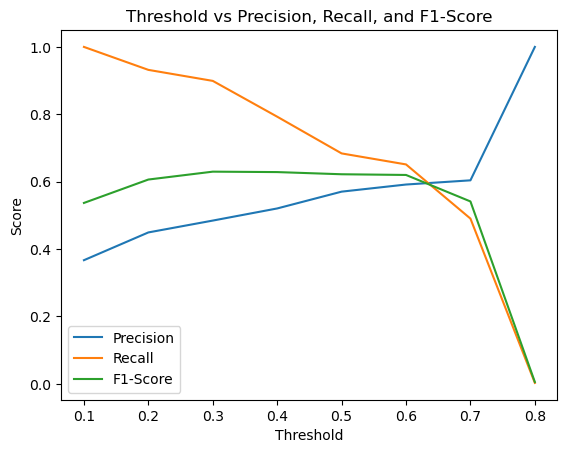

In [14]:
# Ensure y_test is encoded

le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)  # 'No' -> 0, 'Yes' -> 1

# Get predicted probabilities from the best Logistic Regression model
y_pred_prob_lr = best_lr.predict_proba(X_test_encoded)[:, 1]

# Define thresholds to evaluate
thresholds = np.arange(0.1, 0.9, 0.1)
results = []

for threshold in thresholds:
    # Adjust predictions based on the threshold
    y_pred_adjusted = (y_pred_prob_lr >= threshold).astype(int)
    
    # Compute metrics
    precision = precision_score(y_test_encoded, y_pred_adjusted)
    recall = recall_score(y_test_encoded, y_pred_adjusted)
    f1 = f1_score(y_test_encoded, y_pred_adjusted)
    
    results.append({
        "Threshold": threshold,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results
print(results_df)

# Visualize Precision, Recall, and F1-Score
plt.plot(results_df["Threshold"], results_df["Precision"], label="Precision")
plt.plot(results_df["Threshold"], results_df["Recall"], label="Recall")
plt.plot(results_df["Threshold"], results_df["F1-Score"], label="F1-Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Precision, Recall, and F1-Score")
plt.legend()
plt.show()



Interpretation:

Thresholds between 0.3 and 0.5 offer a reasonable trade-off between precision and recall. At thresholds >0.6, the model becomes very conservative, predicting only a few Yes cases (attrition). While precision improves, recall drops sharply. F1-score peaks at around 0.3 and 0.4, indicating a good balance.

Since our priority is recall for attrition cases, I will run the model with a threshold of 0.3

In [15]:
# Adjust the threshold
final_threshold = 0.3
y_pred_final = (y_pred_prob_lr >= final_threshold).astype(int)

# Evaluate performance
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report with Adjusted Threshold:")
print(classification_report(y_test_encoded, y_pred_final))

print("Confusion Matrix with Adjusted Threshold:")
print(confusion_matrix(y_test_encoded, y_pred_final))


Classification Report with Adjusted Threshold:
              precision    recall  f1-score   support

           0       0.88      0.45      0.59       633
           1       0.48      0.90      0.63       367

    accuracy                           0.61      1000
   macro avg       0.68      0.67      0.61      1000
weighted avg       0.74      0.61      0.61      1000

Confusion Matrix with Adjusted Threshold:
[[282 351]
 [ 37 330]]


Interpretation:
Recall for Attrition
Recall = 0.90: This means 90% of employees who actually left (positive cases) were correctly identified by the model.
Recall has significantly improved, which aligns with our business priority to capture as many attrition cases as possible.

Precision for Attrition: Out of all the employees predicted to leave (Yes), only 48% were actually correct.
The lower precision indicates more false positives — cases where the model predicted attrition (Yes), but the employee actually stayed.

False Positives (predicted Yes but actual No) = 351.

The overall accuracy has decreased because the increase in false positives reduces the model's ability to correctly predict non-attrition cases (No).

Overall:
By adjusting the threshold to prioritize recall, we've improved the model's ability to identify attrition cases (true positives), but at the cost of:
More false positives.
Lower precision.
Reduced accuracy.
This trade-off is often acceptable when the cost of missing actual attrition cases (false negatives) is higher than the cost of falsely predicting attrition (false positives).


Business Case for Stressing Recall in Attrition Prediction
In the context of predicting employee attrition, recall (the ability to correctly identify employees who will leave) is prioritized because:

High Cost of Missed Attrition (False Negatives):

Missing actual cases of attrition (employees likely to leave) can have severe consequences:
Operational Disruption: Losing key employees without preparation can disrupt workflows.
Recruitment and Training Costs: Unexpected departures require expensive and time-consuming replacements.
Knowledge Loss: Experienced employees take valuable institutional knowledge with them.
Morale Impact: Undetected dissatisfaction can influence other employees, potentially leading to a wave of departures.
Actionable Insights:

Identifying potential leavers (even if some predictions are false positives) enables HR teams to:
Proactively Intervene: Offer retention strategies like promotions, salary adjustments, or support.
Plan Succession: Prepare for potential gaps by cross-training or hiring in advance.
Lower Impact of False Positives:

Predicting that someone might leave (when they don’t) is less damaging than missing someone who does:
HR can engage with flagged employees to improve their satisfaction and ensure they feel valued.

Why Not Prioritize Precision?
Prioritizing precision would reduce false positives but at the cost of missing actual attrition cases (false negatives). This could leave the company unprepared for significant disruptions, which is often costlier than engaging with employees who are not planning to leave.


In [21]:
# Logistic Regression: Focus on Recall for Attrition Cases OR Logistic Regression Comparison for Attrition Prediction (Yes Cases)

non_tuned_results = {
    "Model": "Logistic Regression (Non-Tuned)",
    "Precision": 0.57,  
    "Recall": 0.69,     
    "F1-Score": 0.62,   
    "ROC-AUC": 0.742,   
}

# Define results for tuned model
tuned_results = {
    "Model": "Logistic Regression (Tuned)",
    "Precision": 0.57,  
    "Recall": 0.68,     
    "F1-Score": 0.62,   
    "ROC-AUC": 0.742,   
}

# Define results for threshold-adjusted model
threshold_adjusted_results = {
    "Model": "Logistic Regression (Threshold-Adjusted)",
    "Precision": 0.48, 
    "Recall": 0.90,     
    "F1-Score": 0.63,   
    "ROC-AUC": 0.742,   
}

# Combine all results into a DataFrame
results_df = pd.DataFrame([non_tuned_results, tuned_results, threshold_adjusted_results])

# Display the results as a table
print(results_df)

                                      Model  Precision  Recall  F1-Score  \
0           Logistic Regression (Non-Tuned)       0.57    0.69      0.62   
1               Logistic Regression (Tuned)       0.57    0.68      0.62   
2  Logistic Regression (Threshold-Adjusted)       0.48    0.90      0.63   

   ROC-AUC  
0    0.742  
1    0.742  
2    0.742  


## Catboost Threshold Adjustment

   Threshold  Precision    Recall  F1-Score
0        0.1   0.390591  0.972752  0.557377
1        0.2   0.435591  0.893733  0.585714
2        0.3   0.485390  0.814714  0.608342
3        0.4   0.513011  0.752044  0.609945
4        0.5   0.556522  0.697548  0.619105
5        0.6   0.585132  0.664850  0.622449
6        0.7   0.587209  0.550409  0.568214
7        0.8   0.581699  0.242507  0.342308


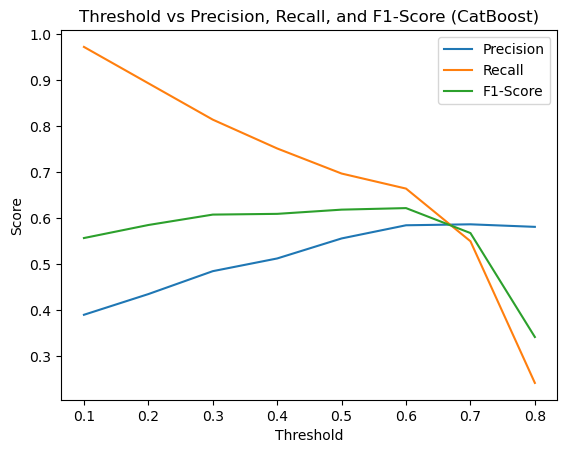

In [26]:
# Get predicted probabilities for CatBoost
y_pred_prob_cb = best_cb.predict_proba(X_test_encoded)[:, 1]

# Define thresholds to evaluate
thresholds = np.arange(0.1, 0.9, 0.1)
results = []

for threshold in thresholds:
    # Adjust predictions based on the threshold
    y_pred_adjusted = (y_pred_prob_cb >= threshold).astype(int)
    
    # Compute metrics
    precision = precision_score(y_test_encoded, y_pred_adjusted)
    recall = recall_score(y_test_encoded, y_pred_adjusted)
    f1 = f1_score(y_test_encoded, y_pred_adjusted)
    
    results.append({
        "Threshold": threshold,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results
print(results_df)

# Visualize Precision, Recall, and F1-Score
plt.plot(results_df["Threshold"], results_df["Precision"], label="Precision")
plt.plot(results_df["Threshold"], results_df["Recall"], label="Recall")
plt.plot(results_df["Threshold"], results_df["F1-Score"], label="F1-Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Precision, Recall, and F1-Score (CatBoost)")
plt.legend()
plt.show()



Interpretation

Since recall for Yes cases (attrition) is the priority, we should select a threshold that maximizes recall while keeping the F1-score reasonably high.
Based on the table, a threshold of 0.3 seems appropriate:
Recall: 81.47%
Precision: 48.39%
F1-score: 60.83%
This threshold provides a good balance between high recall and moderate precision.

In [28]:
# Adjust predictions based on the selected threshold
final_threshold = 0.3
y_pred_final = (y_pred_prob_cb >= final_threshold).astype(int)

# Classification report and confusion matrix for the adjusted threshold
print("Classification Report with Adjusted Threshold:")
print(classification_report(y_test_encoded, y_pred_final))

print("\nConfusion Matrix with Adjusted Threshold:")
print(confusion_matrix(y_test_encoded, y_pred_final))


Classification Report with Adjusted Threshold:
              precision    recall  f1-score   support

           0       0.82      0.50      0.62       633
           1       0.49      0.81      0.61       367

    accuracy                           0.61      1000
   macro avg       0.65      0.66      0.61      1000
weighted avg       0.70      0.61      0.62      1000


Confusion Matrix with Adjusted Threshold:
[[316 317]
 [ 68 299]]


Interpretation:

Precision dropped to 49%, meaning that out of all predicted Yes cases, only 49% were actual Yes cases. This indicates an increase in false positives.
Recall improved significantly to 81%, meaning the model correctly identified 81% of all actual Yes cases. This aligns with the priority of capturing attrition cases.
The F1-Score for Yes cases is 61%, a balanced metric considering the trade-off between precision and recall.

CF:

True Positives (TP): 299 employees were correctly predicted to attrite.
False Positives (FP): 317 employees were predicted to attrite but didn’t.
False Negatives (FN): 68 employees attrited but were predicted not to.
True Negatives (TN): 316 employees were correctly predicted not to attrite.

Overall accuracy is 61%, but this is not the most important metric since our focus is on recall for Yes cases.

Overall,the adjusted threshold improved recall significantly, which aligns with the business goal of reducing attrition risk by capturing as many positive cases as possible. However, it increased false positives, which is an acceptable trade-off in this context.


In [29]:
# Summary table for CatBoost results
catboost_results = pd.DataFrame({
    "Model": ["Non-Tuned CatBoost", "Tuned CatBoost", "Threshold-Adjusted CatBoost"],
    "Precision (Yes)": [0.58, 0.56, 0.49],
    "Recall (Yes)": [0.54, 0.70, 0.81],
    "F1-Score (Yes)": [0.56, 0.62, 0.61],
    "Accuracy": [0.69, 0.69, 0.61],
    "ROC-AUC": [0.71, 0.72, "N/A"]  # Adjusted threshold doesn't use ROC-AUC
})

print(catboost_results)


                         Model  Precision (Yes)  Recall (Yes)  F1-Score (Yes)  \
0           Non-Tuned CatBoost             0.58          0.54            0.56   
1               Tuned CatBoost             0.56          0.70            0.62   
2  Threshold-Adjusted CatBoost             0.49          0.81            0.61   

   Accuracy ROC-AUC  
0      0.69    0.71  
1      0.69    0.72  
2      0.61     N/A  


In [30]:
# Comparison of LR and Catboost refined

# Summary table for final tuned models
final_model_comparison = pd.DataFrame({
    "Model": ["Tuned Logistic Regression", "Threshold-Adjusted CatBoost"],
    "Precision (Yes)": [0.48, 0.49],
    "Recall (Yes)": [0.90, 0.81],
    "F1-Score (Yes)": [0.63, 0.61],
    "Accuracy": [0.61, 0.61],
    "ROC-AUC": [0.74, "N/A"]  # Adjusted threshold doesn't use ROC-AUC
})

print(final_model_comparison)

                         Model  Precision (Yes)  Recall (Yes)  F1-Score (Yes)  \
0    Tuned Logistic Regression             0.48          0.90            0.63   
1  Threshold-Adjusted CatBoost             0.49          0.81            0.61   

   Accuracy ROC-AUC  
0      0.61    0.74  
1      0.61     N/A  


Recommendation: Logistic Regression
The Tuned Logistic Regression model is likely the best candidate for production due to the following reasons:

Higher Recall (90%): It captures more attrition cases, which is the primary goal.
Comparable Precision (48%): Precision is almost the same as the adjusted CatBoost model.
Simplicity and Interpretability: Logistic Regression is easier to implement and explain to stakeholders.

# Cross Validation for the LR model

In [66]:
from sklearn.model_selection import cross_val_score

# Cross-validation with the tuned logistic regression model
cv_scores = cross_val_score(
    estimator=best_lr,                # The tuned logistic regression model
    X=X_train_balanced,               # Training features after preprocessing and balancing
    y=y_train_balanced,               # Training target after balancing
    cv=5,                             # Number of folds for cross-validation
    scoring='roc_auc',                # Evaluation metric: ROC-AUC
    verbose=2                         # Display progress of cross-validation
)

# Display the cross-validation results
print("Cross-Validation ROC-AUC Scores:", cv_scores)
print("Mean ROC-AUC Score:", cv_scores.mean())
print("Standard Deviation of ROC-AUC Scores:", cv_scores.std())


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
Cross-Validation ROC-AUC Scores: [0.74238764 0.76724282 0.7371435  0.75603215 0.77819616]
Mean ROC-AUC Score: 0.7562004549754644
Standard Deviation of ROC-AUC Scores: 0.015229804450249988


# Interpretability of the LR model: Shap values

Number of feature names: 26
All Feature Names: ['Gender_Male', 'Department_Development', 'Department_Management', 'Department_QA', 'Department_Support', 'Overtime_Yes', 'Age', 'Tenure', 'Salary', 'Distance_to_Work', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16']
SHAP Values Shape: (1000, 26)


c:\Users\alexa\anaconda3\envs\employee_attrition_dec24\lib\site-packages\shap\explainers\_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


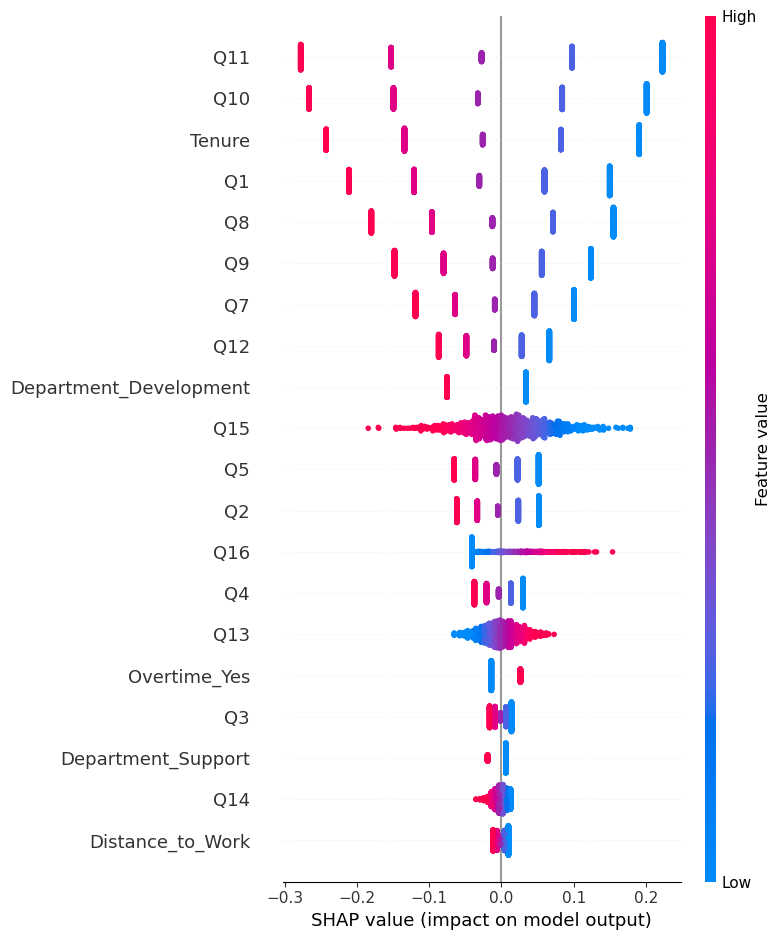

In [63]:
# Get feature names for one-hot-encoded columns
one_hot_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

# Identify the Q12+ feature names (assuming they are in the original DataFrame)
q12_features = [col for col in X.columns if col.startswith('Q')]

# Combine all feature names: one-hot encoded, numerical, and Q12+
all_feature_names = list(one_hot_feature_names) + numerical_features + q12_features

# Verify the feature names and length
print("Number of feature names:", len(all_feature_names))
print("All Feature Names:", all_feature_names)

# Create SHAP explainer
explainer = shap.LinearExplainer(best_lr, X_train_encoded, feature_perturbation="interventional")

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_encoded)

# Print SHAP Values Shape
print("SHAP Values Shape:", shap_values.shape)

# Visualize SHAP summary plot
shap.summary_plot(
    shap_values,
    X_test_encoded,
    feature_names=all_feature_names
)


Interpreation

Feature Importance: The features are listed in descending order of importance (top to bottom).
Features at the top (e.g., Q11, Q10, and Tenure) have the greatest impact on the model's predictions for attrition.

SHAP Values: The x-axis represents the SHAP value, which indicates the direction and magnitude of each feature's influence on the prediction:
Positive SHAP values (to the right of 0): Push the prediction towards Yes (Attrition).
Negative SHAP values (to the left of 0): Push the prediction towards No (No Attrition).

Color Coding: The color of the dots indicates the feature value:
Red: Higher values of the feature.
Blue: Lower values of the feature.

Spread of Points: The spread of points for each feature shows how the feature's values influence the SHAP values across all predictions.
A wide spread means the feature's impact on predictions varies significantly across samples.


Crucial Q12+ questions: 
10.	I have a best friend at work.
11.	In the last six months, someone at work has talked to me about my progress.
and Tenure.


Insights from the Plot
Q11:

This question, "In the last six months, someone at work has talked to me about my progress", is the most influential.
High values (red) push predictions towards No Attrition, while low values (blue) push towards Attrition.
Employees who feel their progress isn’t being discussed are more likely to leave.


A wide spread means that the feature has varying levels of influence on the predictions across different employees. Some employees' responses to Q11 strongly influence their attrition prediction, while for others, the influence is smaller.



Q10:

"I have a best friend at work" also strongly impacts attrition.
Higher values (strong workplace connections) reduce attrition risk.
Tenure:

Longer tenure (red dots) decreases attrition likelihood, while shorter tenure increases it.
Other Q12+ Questions:

Many questions, such as Q1 ("I know what is expected of me at work") and Q8 ("The mission or purpose of my company makes me feel my job is important"), influence predictions. High values tend to reduce attrition risk.
Department:

Employees in Development are more likely to leave (positive SHAP values for Department_Development).
Overtime:

Employees working overtime (Overtime_Yes) lean slightly towards Attrition, indicating that work-life imbalance might be a factor.
Distance_to_Work:

Greater distances have a mild impact on increasing attrition risk.


What This Means
Engagement Metrics (Q12+ Questions):

These are key drivers of attrition. Addressing low engagement on these dimensions could reduce turnover.
Tenure:

Employees with shorter tenure are at higher risk, suggesting that onboarding and early-stage engagement are critical.
Work-Life Balance:

The impact of overtime and commuting indicates that balancing workloads and offering remote work could help retain employees.

